In [1]:

import matplotlib
%matplotlib inline

#matplotlib.use('TkAgg')
import os
os.system('ipcluster start -n 8 --profile=default & sleep 5 & python stdout_worker.py &')
import ipyparallel as ipp
rc = ipp.Client(profile='default')
from ipyparallel import depend, require, dependent
dview = rc[:]


In [2]:


# !ulimit -n 2048 
# There is on issue on the Mac with the number of open file handles.  
# I think there is a file leak in LEMS or somewhere else and the command above needs to be run
# in the shell that spawned this notebook before this code can be run to completion.

# coding: utf-8

################
# GA parameters:
################
MU = 12; NGEN = 25; CXPB = 0.7555
USE_CACHED_GA = True
# about 8 models will be made, excluding rheobase search.

################
# Grid search parameters:
# only 5 models, will be made excluding rheobase search
################
npoints = 2
nparams = 10
from neuronunit.optimization.model_parameters import model_params
provided_keys = list(model_params.keys())
#provided_keys = None
#provided_keys = ['b','a','vpeak','v0','vt'] #implied number parameters is 2

USE_CACHED_GS = True

In [3]:
import pickle
import numpy as np

In [4]:
from neuronunit.optimization.nsga_object import NSGA
from neuronunit.optimization import exhaustive_search as es
from neuronunit.optimization import evaluate_as_module as eam


Getting Rheobase cached data value for from AIBS dataset 354190013
/home/jovyan/neuronunit/neuronunit/optimization/neuroelectro.pickle got here
/home/jovyan/neuronunit/neuronunit/optimization
attempting to recover from pickled file
/home/jovyan/neuronunit/neuronunit/models/__init__.py


/home/jovyan/neuronunit/neuronunit/models/backends.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.5/site-packa

In [5]:

if USE_CACHED_GA:
    from deap import creator
    from deap import base
    from neuronunit.optimization import evaluate_as_module as eam
    NSGAO = NSGA()
    NSGAO.setnparams(nparams=nparams,provided_keys=provided_keys)
    td = eam.get_trans_dict(NSGAO.subset)
    weights = tuple([-1.0 for i in range(0,8)])
    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)
    [invalid_dtc, pop, logbook, fitnesses, history, pf] = pickle.load(open('ga_dump.p','rb'))
else:
    NSGAO = NSGA()
    NSGAO.setnparams(nparams=nparams,provided_keys=provided_keys)
    invalid_dtc, pop, logbook, fitnesses, history, pf = NSGAO.main(MU, NGEN)
    with open('ga_dump.p','wb') as f:
       pickle.dump([invalid_dtc, pop, logbook, fitnesses, history, pf],f)

/home/jovyan/neuronunit/neuronunit/optimization/nsga_parallel.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.5

/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


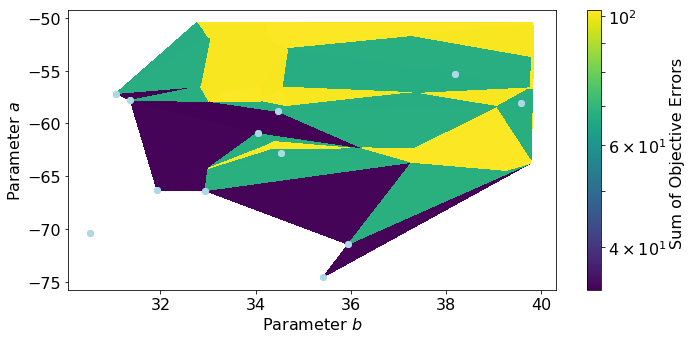

In [14]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size':16})
import matplotlib.pyplot as plt
all_inds = history.genealogy_history.values()
sums = np.array([np.sum(ind.fitness.values) for ind in all_inds])
quads = []
for k in range(1,9):
    for i,j in enumerate(td):
        if i+k < 10:
            quads.append((td[i],td[i+k],i,i+k))
all_inds1 = list(history.genealogy_history.values())
x = 4
z = -3 

def plot_surface(x,z):
    ab = [ (all_inds1[x],all_inds1[z]) for y in all_inds1 ]
    xs = np.array([ind[x] for ind in all_inds])
    ys = np.array([ind[z] for ind in all_inds])
    min_ys = ys[np.where(sums == np.min(sums))]
    min_xs = xs[np.where(sums == np.min(sums))]
    plt.clf()
    fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')
    trip_axis = ax_trip.tripcolor(xs,ys,sums,20,norm=matplotlib.colors.LogNorm())
    plot_axis = ax_trip.plot(list(min_xs), list(min_ys), 'o', color='lightblue',label='global minima')
    fig_trip.colorbar(trip_axis, label='Sum of Objective Errors ')
    ax_trip.set_xlabel('Parameter $ b$')
    ax_trip.set_ylabel('Parameter $ a$')
    plot_axis = ax_trip.plot(list(min_xs), list(min_ys), 'o', color='lightblue')
    fig_trip.tight_layout()
    fig_trip.show()
plot_surface(4,-3)

/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


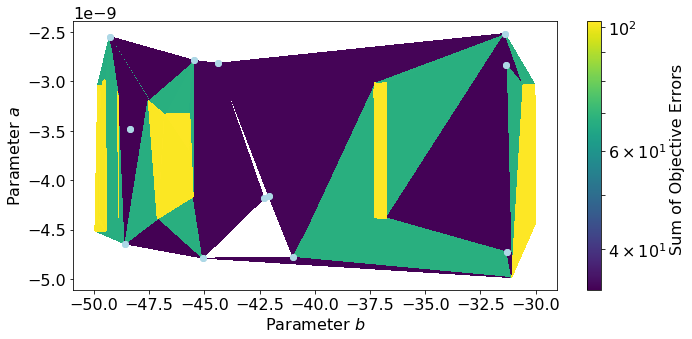

In [15]:

plot_surface(1,2)

/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


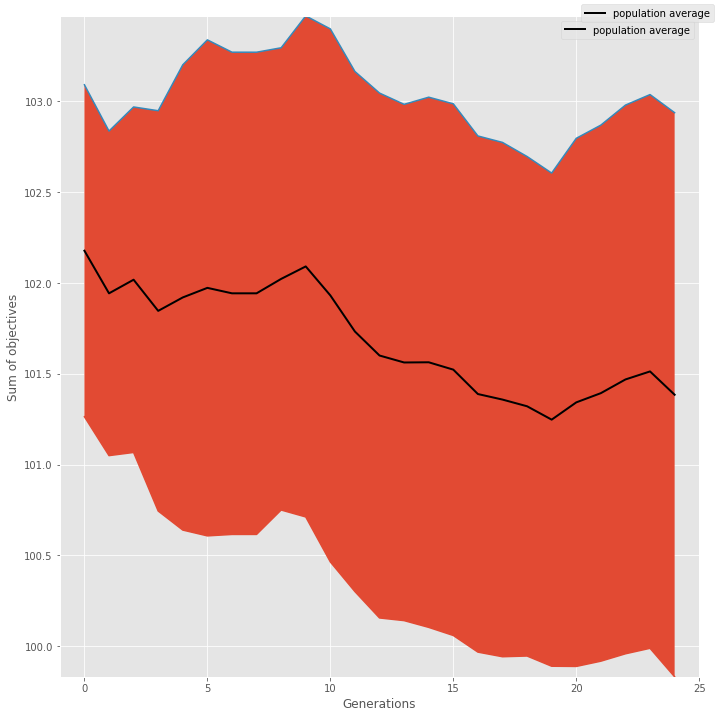

In [16]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
log = logbook
#plt.clf()
plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
gen_numbers =[ i for i in range(0,len(log.select('gen'))) ]
mean = np.array([ np.sum(i) for i in log.select('avg')])
std = np.array([ np.sum(i) for i in log.select('std')])
minimum = np.array([ np.sum(i) for i in log.select('min')])
stdminus = mean - std
stdplus = mean + std
try:
    assert len(gen_numbers) == len(stdminus) == len(stdplus)
except:
    pass

axes.plot(
    gen_numbers,
    mean,
    color='black',
    linewidth=2,
    label='population average')
axes.fill_between(gen_numbers, stdminus, stdplus)
axes.plot(gen_numbers, stdminus)
axes.plot(gen_numbers, stdplus)
axes.set_xlim(np.min(gen_numbers) - 1, np.max(gen_numbers) + 1)
axes.set_xlabel('Generations')
axes.set_ylabel('Sum of objectives')
axes.set_ylim([np.min(stdminus), np.max(stdplus)])
axes.legend()
fig.tight_layout()
fig.legend()
fig.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


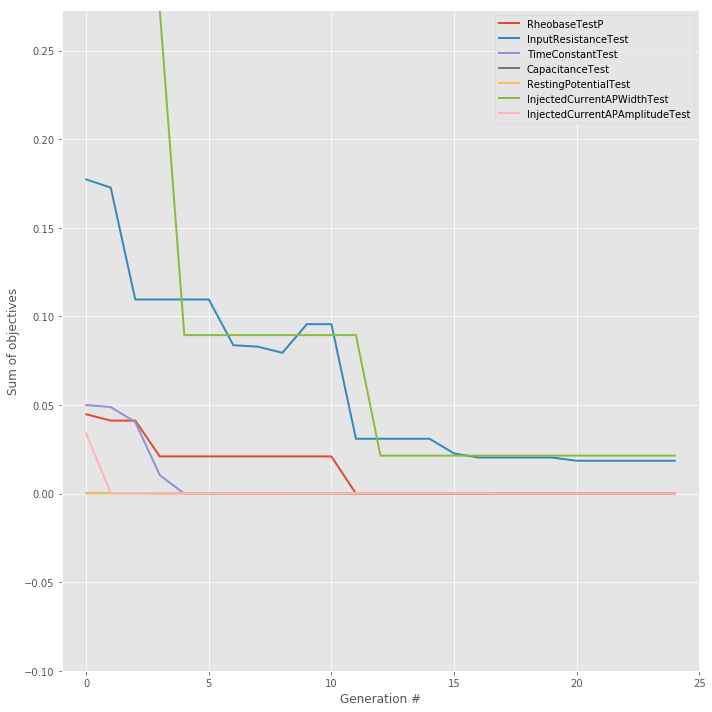

In [17]:
#import matplotlib
#matplotlib.use('TkAgg')
#import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from neuronunit.optimization import get_neab
plt.clf()
plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
gen_numbers = log.select('gen')
minimum = log.select('min')
mean = log.select('mean')
objective_labels = [ str(t) for t in get_neab.tests ]
mins_components_plot = log.select('min')
components = {}
for i in range(0,7):
    components[i] = []
    for l in mins_components_plot:
        components[i].append(l[i])
maximum = 0.0
for keys in components:

    axes.plot(
        gen_numbers,
        components[keys],
        linewidth=2,
        label=str(objective_labels[keys])
        )
    if np.max(components[keys]) > maximum:
        maximum = np.max(components[keys])

axes.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)
axes.set_xlabel('Generation #')
axes.set_ylabel('Sum of objectives')
axes.set_ylim([-0.1, maximum])
axes.legend()
fig.tight_layout()
fig.show()

In [ ]:
if USE_CACHED_GS:
       #dtcpopg = pickle.load(open('grid_dump.p','rb'))
    first_half = pickle.load(open('grid_dump_first_half.p','rb'))
    second_half = pickle.load(open('grid_dump_second_half.p','rb'))
    second_half.extend(first_half)
    dtcpopg = second_half
    print(dtcpopg)
else:
    from neuronunit.optimization import exhaustive_search
    grid_points = exhaustive_search.create_grid(npoints = npoints,nparams = nparams,provided_keys = provided_keys )
    dlist = list(dview.map_sync(exhaustive_search.update_dtc_pop,grid_points))
    from neuronunit.optimization import get_neab
    for d in dlist:
        d.model_path = get_neab.LEMS_MODEL_PATH
        d.LEMS_MODEL_PATH = get_neab.LEMS_MODEL_PATH
        print(d.model_path)
    #with open('grid_dump.p','wb') as f:
     #  pickle.dump(dlist,f)
    # this is a big load on memory so divide it into thirds.

    dlist_first_third = dlist[0:int(len(dlist)/3)]
    dlist_second_third = dlist[int(len(dlist)/3):int(2*len(dlist)/3)]
    dlist_final_third = dlist[int(2*len(dlist)/3):-1]
    from neuronunit.optimization.exhaustive_search import dtc_to_rheo
    from neuronunit.optimization.exhaustive_search import parallel_method
    # uncomment if list is very small
    #if int(len(dlist)/10) == 0:
    #    dlist_first_half =[ dlist ]
    #dlist_first_3rd = compute_half(dlist_first_half)

    with open('grid_dump_first_3rd.p','wb') as f:
       pickle.dump(dlist_first_3rd,f)
    # Garbage collect a big memory burden.
    dlist_first_3rd = None
    dlist_second_3rd = compute_half(dlist_second_half)

    with open('grid_dump_second_3rd.p','wb') as f:
       pickle.dump(dlist_second_3rd,f)
   # Garbage collect a big memory burden.
    dlist_second_3rd = None

    dlist_final_3rd = compute_half(dlist_final_half)
    with open('grid_dump_final_3rd.p','wb') as f:
       pickle.dump(dlist_final_3rd,f)
    # Garbage collect a big memory burden.
    dlist_final_3rd = None

In [ ]:

for d in dtcpopg:
    if d.scores['RheobaseTestP'] == None:
        d.scores['RheobaseTestP'] = 10


def error(dtc):
    """
    Overall error function for a DTC
    Returns the root-mean-square error over all the tests
    """
    return np.sqrt(np.mean(np.square(list(dtc.scores.values()))))

def sorted_dtcs(dtcpop):
    """
    Returns dtc,error tuples sorted from low to high error
    """
    return sorted([(dtc,error(dtc)) for dtc in dtcpop],key=lambda x:x[1])


def sorted_history(pop):
    """
    Returns dtc,error tuples sorted from low to high error
    """
    return sorted([ind.fitness for ind in pop],key=lambda x:x[1])



minimagr_dtc, mini = sorted_dtcs(dtcpopg)[0]
maximagr_dtc, maxi = sorted_dtcs(dtcpopg)[-1]

In [ ]:
def pop2dtc(pop1,NSGAO):

    from deap import base, creator
    toolbox = base.Toolbox()
    NDIM = 10
    weights = tuple([1.0 for i in range(0,NDIM)])
    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)
    from neuronunit.optimization import evaluate_as_module as eam
    td = eam.get_trans_dict(NSGAO.subset)
    dtc_pop = eam.update_dtc_pop(pop1,td)
    assert len(pop1) == len(dtc_pop)

    from neuronunit.optimization.exhaustive_search import dtc_to_rheo

    from neuronunit.optimization import model_parameters as modelp
    dtcpop = list(map(dtc_to_rheo,dtc_pop))
    for i,p in enumerate(pop1):
        for val in list(p.fitness.values):
            if val==-100:
                val = 100
        dtc_pop[i].scores = p.fitness.values
        dtc_pop[i].error = None
        dtc_pop[i].error = np.sqrt(np.mean(np.square(list(p.fitness.values))))
    for i,p in enumerate(dtc_pop):
        print(i,p,dir(p))

    sorted_list  = sorted([(dtc,dtc.error) for dtc in dtc_pop],key=lambda x:x[1])
    return sorted_list, dtc_pop

sorted_list_pf, pareto_dtc = pop2dtc(pf,NSGAO)
sorted_list_pf, pareto_dtc = pop2dtc(pf,NSGAO)

h = list(history.genealogy_history.values())
sorted_list_h, dtc_pop = pop2dtc(h,NSGAO)
minimaga_dtc = sorted_list_pf[0][0]
maximaga_dtc = sorted_list_pf[-1][0]

#history_fitness = sorted_history(h)
miniga = sorted_list_pf[0][1]
maxiga = sorted_list_pf[-1][1]

sdtc = sorted_dtcs(invalid_dtc)
miniga = sdtc[0][1]
maxiga = sdtc[-1][1]



    Starting simulation in NEURON of 500.0ms generated from NeuroML2 model...

Population RS_pop contains 1 instance(s) of component: RS of type: izhikevich2007Cell
[('c', '-49.8269798034'), ('vt', '-3.02778580732e-09'), ('b', '34.1000836507'), ('d', '0.00110697201329'), ('vr', '-56.5555037127'), ('vpeak', '-58.5825472052'), ('a', '9.39533963754e-05'), ('k', '-59.3915811599'), ('v0', '0.211876570711'), ('C', '0.196606744929')] {'c': '-49.8269798034', 'vt': '-3.02778580732e-09', 'b': '34.1000836507', 'd': '0.00110697201329', 'vr': '-56.5555037127', 'vpeak': '-58.5825472052', 'a': '9.39533963754e-05', 'k': '-59.3915811599', 'v0': '0.211876570711', 'C': '0.196606744929'}


In [ ]:
# quantize distance between minimimum error and maximum error.
quantize_distance = list(np.linspace(mini,maxi,10))

# check that the nsga error is in the bottom 1/5th of the entire error range.
print('Report: ')
print("Success" if bool(miniga < quantize_distance[2]) else "Failure")
print("The nsga error %f is in the bottom 1/5th of the entire error range" % miniga)
print("Minimum = %f; 20th percentile = %f; Maximum = %f" % (mini,quantize_distance[2],maxi))

In [ ]:

# This function reports on the deltas brute force obtained versus the GA found attributes.
from neuronunit.optimization import model_parameters as modelp
mp = modelp.model_params
for k,v in minimagr.attrs.items():
    #hvgrid = np.linspace(np.min(mp[k]),np.max(mp[k]),10)
    dimension_length = np.max(mp[k]) - np.min(mp[k])
    solution_distance_in_1D = np.abs(float(minimaga.attrs[k]))-np.abs(float(v))
    relative_distance = dimension_length/solution_distance_in_1D
    print('the difference between brute force candidates model parameters and the GA\'s model parameters:')
    print(float(minimaga.attrs[k])-float(v),minimaga.attrs[k],v,k)
    print('the relative distance scaled by the length of the parameter dimension of interest:')
    print(relative_distance)

In [ ]:
print('the difference between the bf error and the GA\'s error:')
print('grid search:')
from numpy import square, mean, sqrt
rmsg=sqrt(mean(square(list(minimagr.scores.values()))))
print(rmsg)
print('ga:')
rmsga=sqrt(mean(square(list(minimaga.scores.values()))))
print(rmsga)

# Two things to find:
# How close togethor are the model parameters in parameter space (hyper volume), relative to the dimensions of the HV?
# ie get the euclidian distance between the two sets of model parameters.